In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import stats
import yaml
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.maps import MapAxis, WcsGeom, Map

import warnings
warnings.filterwarnings('ignore')

# choose your source and model

In [2]:
source = 'Crab'
pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size

from gammapy.modeling.models import GaussianSpatialModel, LogParabolaSpectralModel
spatial=GaussianSpatialModel(lon_0=83.6333313*u.deg, lat_0=22.01444435*u.deg, sigma=0.016*u.deg, reference='1 TeV', frame='icrs')
spectral=LogParabolaSpectralModel(amplitude='3.84e-11 cm-2 s-1 TeV-1', alpha=2.5, beta=0.105, reference='1TeV')
main_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')

In [2]:
source = 'NGC253'
pos = SkyCoord(83.6333313*u.deg, 22.01444435*u.deg, frame='icrs')
mask_sources = [[pos.ra.deg, pos.dec.deg, 0.4]] # given as a list, position and size

from gammapy.modeling.models import PointSpatialModel, PowerLawSpectralModel
spatial=PointSpatialModel(lon_0=11.8875*u.deg, lat_0=-25.2883*u.deg, reference='1 TeV', frame='icrs')
spectral=PowerLawSpectralModel(amplitude='1.79e-13 cm-2 s-1 TeV-1', index=2.848)
main_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')

# starting point

In [3]:
# loading general parameters

with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
energy_bins = np.logspace(-1, 2, N_ebins+1)

In [4]:
stacked = MapDataset.read(f'{source}/stacked.fits')
sys_er = np.loadtxt(f'{source}/sysamplitude_percentage.txt')

# checks of dataset

In [5]:
original_mask_safe = stacked.mask_safe.data.copy()
x_axis=stacked.counts.geom.axes['energy'].center.value

for mask_pos in mask_sources:
    stacked.mask_safe &= ~stacked.counts.geom.region_mask(f"icrs;circle({mask_pos[0]}, {mask_pos[1]}, {mask_pos[2]})")

Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within


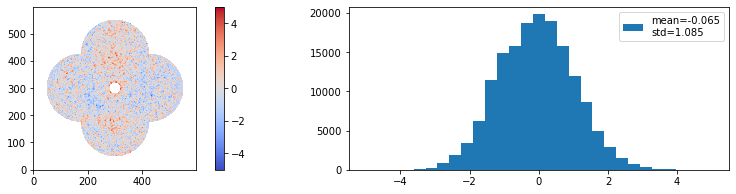

In [6]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.07 deg",
    selection_optional=[],
    energy_edges=[0.1, 100] * u.TeV,
)
result = estimator.run(stacked)

fig, ax = plt.subplots(1,2, figsize=(15, 3))
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
data=result["sqrt_ts"].data.ravel()
ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
plt.legend()

Text(0.5, 1.0, 'Crab - significance map')

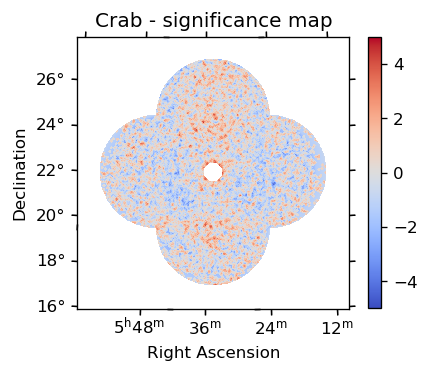

In [7]:
plt.figure(figsize=(4,3), dpi=120)
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5);
plt.title(f'{source} - significance map')
#plt.savefig(f'{source}/plots/{source}_offregion_significance_map.png')

Text(0.5, 0, 'significance [$\\sigma$]')

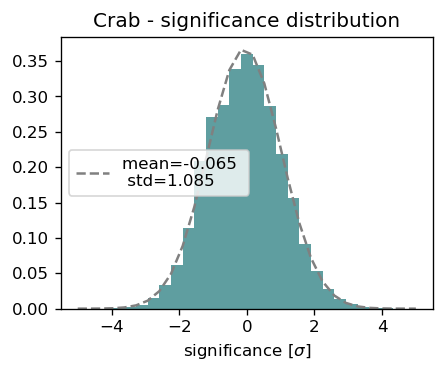

In [8]:
from scipy.stats import norm
bins = np.linspace(-5,5,30)
data=result["sqrt_ts"].data.ravel()

plt.figure(figsize=(4,3), dpi=120)

plt.hist(data, bins=bins, color='cadetblue', density=True);

mu, std = norm.fit(data[~np.isnan(data)])
p = norm.pdf(bins, mu, std)
plt.plot(bins, p, 'gray', ls='--', label=f'mean={mu:.3f} \n std={std:.3f}')

plt.legend(loc='center left')
plt.title(f'{source} - significance distribution')
plt.xlabel(r'significance [$\sigma$]')
#plt.savefig(f'{source}/plots/{source}_offregion_significance_distribution.png')

Text(0.5, 0, 'energy [TeV]')

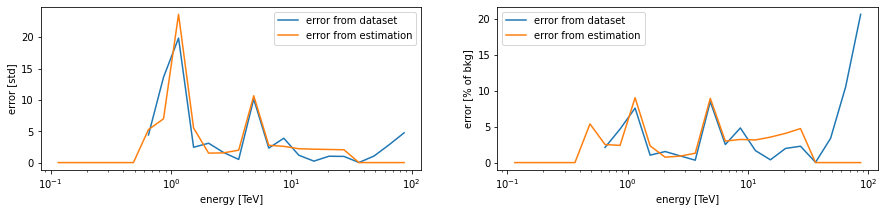

In [9]:
c = np.sum((stacked.counts*stacked.mask_safe).data, axis=(1,2))
b = np.sum((stacked.background*stacked.mask_safe).data, axis=(1,2))
error_std= abs(c-b)/np.sqrt(b)
error_percentage= 100*abs(c-b)/b

fig, ax = plt.subplots(1,2, figsize=(15, 3))

ax[0].plot(x_axis, error_std, label='error from dataset')
ax[0].plot(x_axis, abs(sys_er*np.sqrt(b))/100, label='error from estimation')
ax[0].set_xscale('log')
ax[0].set_ylabel(f'error [std]')
ax[0].legend()
ax[0].set_xlabel('energy [TeV]')

ax[1].plot(x_axis, error_percentage, label='error from dataset')
ax[1].plot(x_axis, abs(sys_er), label='error from estimation')
ax[1].set_xscale('log')
ax[1].set_ylabel(f'error [% of bkg]')
ax[1].legend()
ax[1].set_xlabel('energy [TeV]')

Text(0.5, 0.98, 'Crab - error estimation')

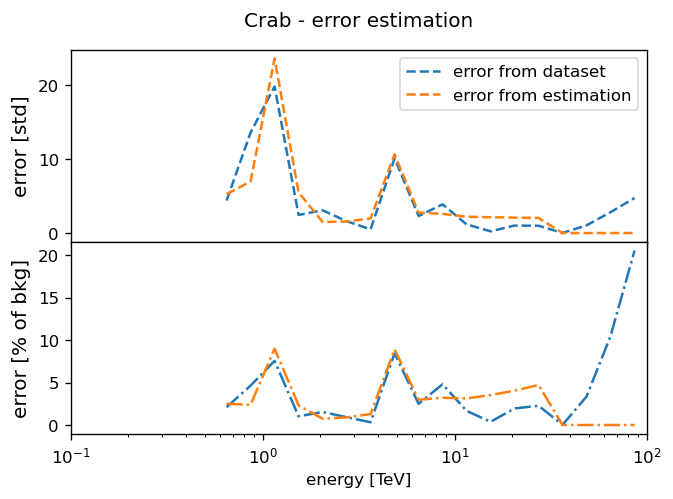

In [10]:
c = np.sum((stacked.counts*stacked.mask_safe).data, axis=(1,2))
b = np.sum((stacked.background*stacked.mask_safe).data, axis=(1,2))
mask = b!=0
error_std= abs(c-b)/np.sqrt(b)
error_percentage= 100*abs(c-b)/b

fig = plt.figure(dpi=120)

ax0 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])

ax0.plot(x_axis[mask], error_std[mask], label='error from dataset', ls='--')
ax0.plot(x_axis[mask], (abs(sys_er*np.sqrt(b))/100)[mask], label='error from estimation', ls='--')
ax0.set_xscale('log')
ax0.set_ylabel(f'error [std]', size=12)
ax0.legend()
ax0.set_xticklabels([])
ax0.set_xlim(1e-1, 1e2)

ax1.plot(x_axis[mask], error_percentage[mask], label='error from dataset', ls='-.')
ax1.plot(x_axis[mask], abs(sys_er)[mask], label='error from estimation', ls='-.')
ax1.set_xscale('log')
ax1.set_ylabel(f'error [% of bkg]', size=12)
#ax1.legend()
ax1.set_xlabel('energy [TeV]')
ax1.set_xlim(1e-1, 1e2)

plt.suptitle(f'{source} - error estimation')
#plt.savefig(f'{source}/plots/{source}_error_estimation.png')

In [26]:
runlist = np.loadtxt(f'{source}/runlist.txt')

run_info = np.zeros((len(runlist), 3))
for hessera in ['hess1', 'hess2']:
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    obs_table = ds.obs_table
    mask_runs = [True if obsid in runlist else False for obsid in obs_table['OBS_ID']]
    if hessera == 'hess1':
        len_mask = np.sum(mask_runs)
        run_info[:len_mask, 0] = obs_table[mask_runs]['OBS_ID']
        run_info[:len_mask, 1] = obs_table[mask_runs]['ZEN_PNT']
        run_info[:len_mask, 2] = obs_table[mask_runs]['MUONEFF']
    else:
        run_info[len_mask:, 0] = obs_table[mask_runs]['OBS_ID']
        run_info[len_mask:, 1] = obs_table[mask_runs]['ZEN_PNT']
        run_info[len_mask:, 2] = obs_table[mask_runs]['MUONEFF']


(0.05, 0.1)

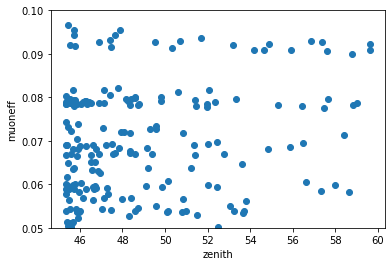

In [27]:
plt.scatter(run_info[:, 1], run_info[:, 2])
plt.xlabel('zenith')
plt.ylabel('muoneff')
plt.ylim(0.05, 0.1)

Text(0.5, 0.98, 'Crab - run distribution')

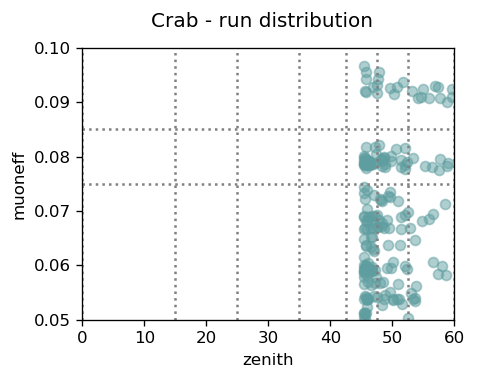

In [28]:
zen_bins = cfg['zen_bins']

plt.figure(figsize=(4,3), dpi=120)

plt.scatter(run_info[:, 1], run_info[:, 2], marker='o', color='cadetblue', alpha=0.5)
plt.xlabel('zenith')
plt.ylabel('muoneff')
plt.ylim(0.05, 0.1)
plt.xlim(0, 60)

for zen in zen_bins:
    plt.axvline(zen, ls=':', color='gray')
plt.axhline(0.075, ls=':', color='gray')
plt.axhline(0.085, ls=':', color='gray')
    
plt.suptitle(f'{source} - run distribution')
#plt.savefig(f'{source}/plots/{source}_run_distribution.png')

# analysis with gammapy

In [14]:
stacked.models = Models([main_source, FoVBackgroundModel(dataset_name=stacked.name)])
stacked.mask_safe = Map.from_geom(geom=stacked.counts.geom, data=original_mask_safe)   

#stacked.models[-1].parameters['tilt'].frozen=False

In [15]:
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : main source
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   3.84e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    alpha                   :      2.500   +/-    0.00             
    beta                    :      0.105   +/-    0.00             
    lon_0                   :     83.633   +/-    0.00 deg         
    lat_0                   :     22.014   +/-    0.00 deg         
    sigma                   :      0.016   +/-    0.00 deg         
    e            (frozen)   :      0.000                   
    phi          (frozen)   :      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : BZUsVSzc-bkg
  Datasets names            : ['BZUsVSzc']
  Spectral model type  

In [16]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[stacked])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (89.09546826, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (89.09546826, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (78.17119434, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (78.17119434, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 27.44400828)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 27.44400828)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 16.49820823)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement


In [17]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 252
	total stat : -1251607.67

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 252
	total stat : -1251607.67




In [18]:
with open(f'{source}/standard_model.yml', 'w') as outfile:
    yaml.dump(stacked.models.to_dict(), outfile, default_flow_style=False)
with open(f'{source}/standard_bgmodel.yml', 'w') as outfile:
    yaml.dump(stacked.background_model.to_dict(), outfile, default_flow_style=False)

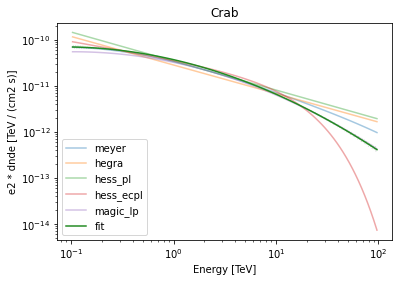

In [19]:
if source == 'Crab':
    from gammapy.modeling.models import create_crab_spectral_model
    crab_types = ['meyer', 'hegra', 'hess_pl', 'hess_ecpl', 'magic_lp']
    for cr in crab_types:
        create_crab_spectral_model(cr).plot(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, label=cr, alpha=0.4)    

stacked.models[0].spectral_model.plot_error(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, facecolor="none", hatch=".....")        
stacked.models[0].spectral_model.plot(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, label='fit', color='forestgreen')
        
plt.legend()
plt.title(source)
plt.show()

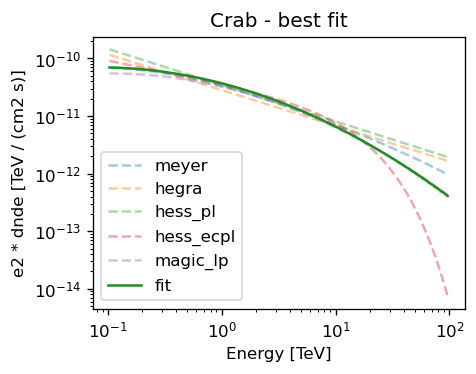

In [23]:
plt.figure(figsize=(4,3), dpi=120)

if source == 'Crab':
    from gammapy.modeling.models import create_crab_spectral_model
    crab_types = ['meyer', 'hegra', 'hess_pl', 'hess_ecpl', 'magic_lp']
    for cr in crab_types:
        create_crab_spectral_model(cr).plot(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, label=cr, alpha=0.4, ls='--')    

stacked.models[0].spectral_model.plot_error(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, facecolor="none", hatch=".....")        
stacked.models[0].spectral_model.plot(energy_bounds=[0.1, 100]*u.TeV, energy_power=2, label='fit', color='forestgreen')
        
plt.legend()
plt.title(f'{source} - best fit')
plt.show()

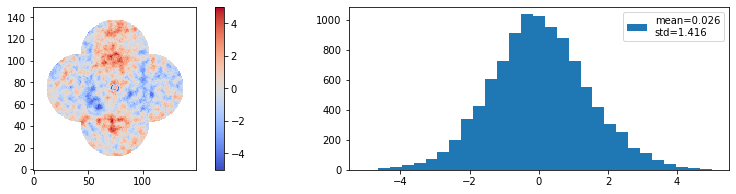

In [24]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=[0.1, 100] * u.TeV,
)
result = estimator.run(stacked)

fig, ax = plt.subplots(1,2, figsize=(15, 3))
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
data=result["sqrt_ts"].data.ravel()
ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
plt.legend()

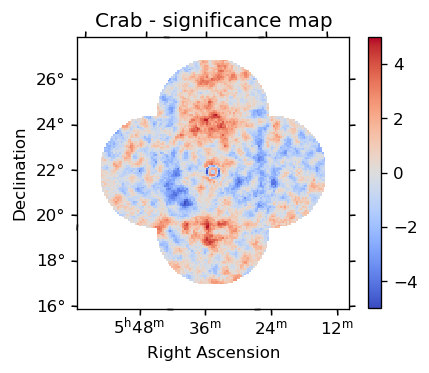

In [25]:
plt.figure(figsize=(4,3), dpi=120)
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5);
plt.title(f'{source} - significance map')
plt.savefig(f'{source}/plots/{source}_ffullregion_significance_map.png')

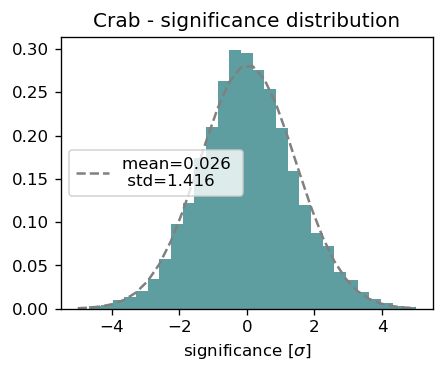

In [26]:
from scipy.stats import norm
bins = np.linspace(-5,5,30)
data=result["sqrt_ts"].data.ravel()

plt.figure(figsize=(4,3), dpi=120)

plt.hist(data, bins=bins, color='cadetblue', density=True);

mu, std = norm.fit(data[~np.isnan(data)])
p = norm.pdf(bins, mu, std)
plt.plot(bins, p, 'gray', ls='--', label=f'mean={mu:.3f} \n std={std:.3f}')

plt.legend(loc='center left')
plt.title(f'{source} - significance distribution')
plt.xlabel(r'significance [$\sigma$]')
plt.savefig(f'{source}/plots/{source}_fullregion_significance_distribution.png')

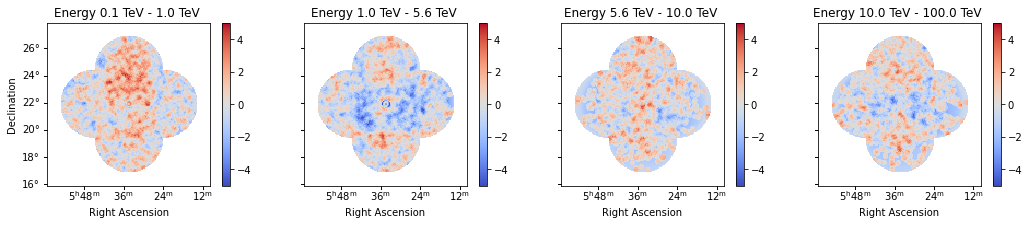

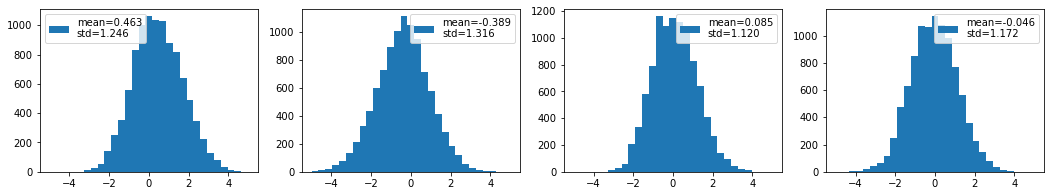

In [27]:
from gammapy.estimators import ExcessMapEstimator

energy_edges = [0.1,1, 5, 10, 100] * u.TeV
estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=energy_edges,
)
result = estimator.run(stacked)

result["sqrt_ts"].plot_grid(
    figsize=(18, 3), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=4);

fig, ax = plt.subplots(1,4, figsize=(18, 3))
for i in range(4):
    data=result["sqrt_ts"].data[i].ravel()
    ax[i].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
    ax[i].legend()


In [32]:
energy_edges = [0.1,1, 5, 10, 100] * u.TeV

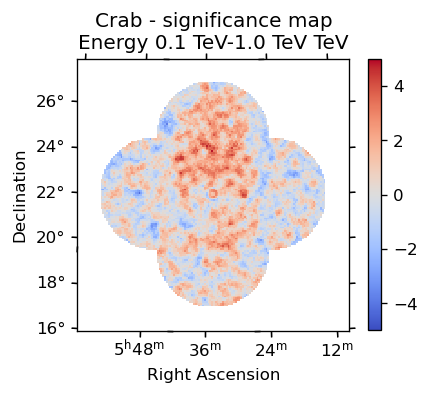

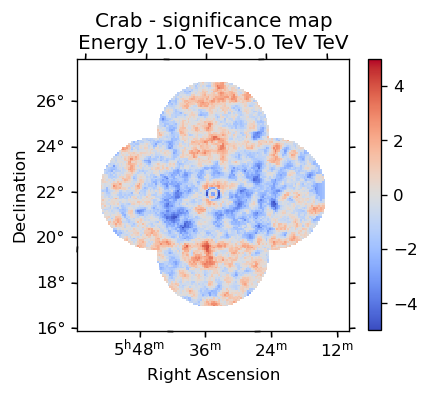

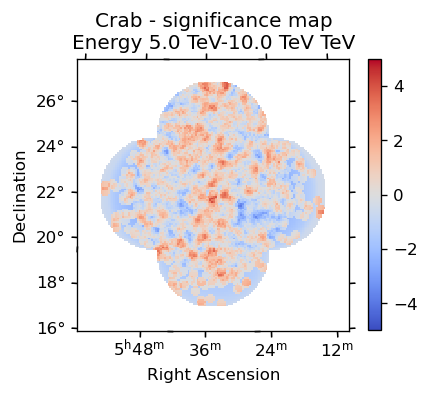

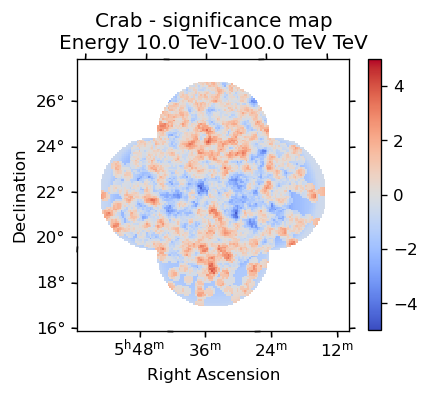

In [35]:
for idx in range(4):
    plt.figure(figsize=(4,3), dpi=120)
    result["sqrt_ts"].slice_by_idx({'energy':idx}).plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5);
    plt.title(f'{source} - significance map\nEnergy {energy_edges[idx]}-{energy_edges[idx+1]} TeV')
    plt.savefig(f'{source}/plots/{source}_fullregion_significance_map_energyband_{idx}.png')
    plt.show()

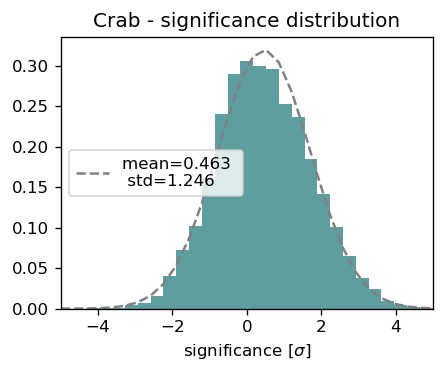

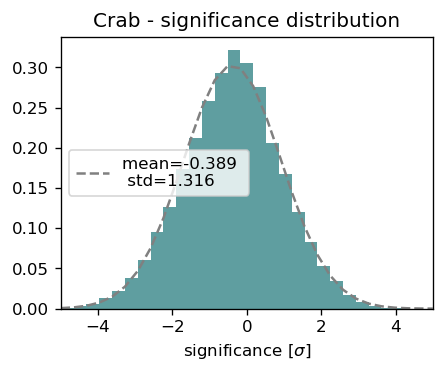

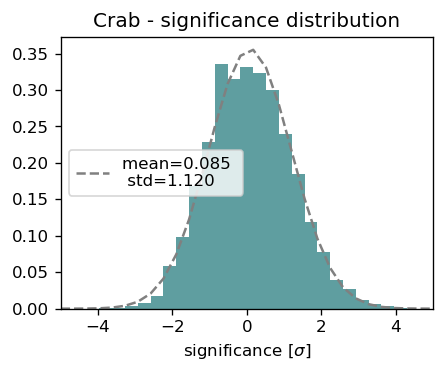

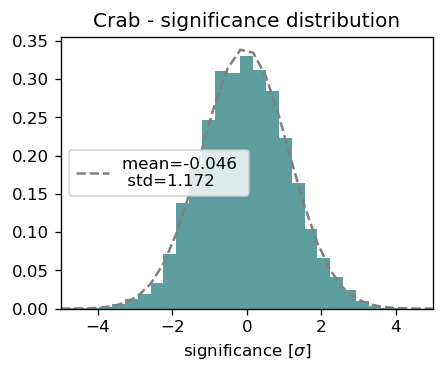

In [37]:
from scipy.stats import norm
bins = np.linspace(-5,5,30)
for idx in range(4):
    data=result["sqrt_ts"].slice_by_idx({'energy':idx}).data.ravel()
    plt.figure(figsize=(4,3), dpi=120)
    plt.hist(data, bins=bins, color='cadetblue', density=True);

    mu, std = norm.fit(data[~np.isnan(data)])
    p = norm.pdf(bins, mu, std)
    plt.plot(bins, p, 'gray', ls='--', label=f'mean={mu:.3f} \n std={std:.3f}')

    plt.legend(loc='center left')
    plt.title(f'{source} - significance distribution')
    plt.xlabel(r'significance [$\sigma$]')
    plt.savefig(f'{source}/plots/{source}_fullregion_significance_distribution_energyband_{idx}.png')
    plt.xlim(-5,5)
    plt.show()

In [39]:
from gammapy.estimators import FluxPoints, FluxPointsEstimator

fp_hess = FluxPointsEstimator(
    energy_edges=stacked.counts.geom.axes['energy'].edges,
    source=stacked.models[0].name,
).run([stacked])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.63060473, 22.01814058)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.63060473, 22.01814058)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.63060473, 22.01814058)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.63060473, 22.01814058)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.63060473, 22.01814058)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.63060473, 22.01814058)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.63060473, 22.01814058)> is outside valid IRF map range, using nearest IRF defined within
Position <Sky

In [47]:
fp_hess.sqrt_ts_threshold_ul = 3

In [49]:
fp_hess.

AttributeError: 'FluxPoints' object has no attribute 'table'

Text(0.5, 1.0, 'main source')

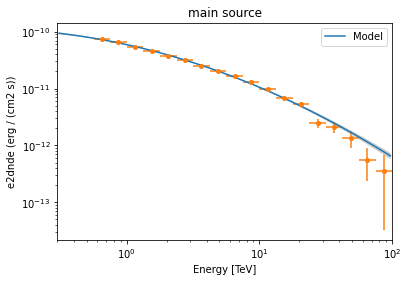

In [48]:
x_axis = stacked.counts.geom.axes['energy'].center.value

energy_bounds = [0.3, 100] * u.TeV
sed_type = "e2dnde"
name_list = ['bkg_peak', 'edisp', 'bkgpeak_lesssource']

ax = stacked.models[0].spectral_model.plot(
    energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
stacked.models[0].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
fp_hess.plot(ax=ax, sed_type=sed_type)
ax.set_xlim(energy_bounds)
plt.legend()
plt.title(stacked.models[0].name)

Text(0.5, 0, 'energy [TeV]')

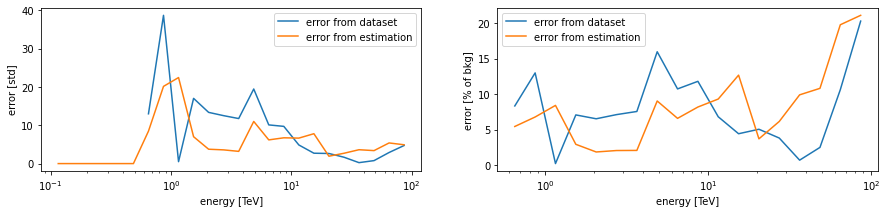

In [81]:
c = np.sum((stacked.counts*stacked.mask_safe).data, axis=(1,2))
b = np.sum((stacked.background*stacked.mask_safe).data, axis=(1,2))
error_std= abs(c-b)/np.sqrt(b)
error_percentage= 100*abs(c-b)/b

fig, ax = plt.subplots(1,2, figsize=(15, 3))

ax[0].plot(x_axis, error_std, label='error from dataset')
ax[0].plot(x_axis, sys_er, label='error from estimation')
ax[0].set_xscale('log')
ax[0].set_ylabel(f'error [std]')
ax[0].legend()
ax[0].set_xlabel('energy [TeV]')

ax[1].plot(x_axis, error_percentage, label='error from dataset')
ax[1].plot(x_axis, 100*sys_er/np.sqrt(b), label='error from estimation')
ax[1].set_xscale('log')
ax[1].set_ylabel(f'error [% of bkg]')
ax[1].legend()
ax[1].set_xlabel('energy [TeV]')

Text(0.5, 0, 'energy [TeV]')

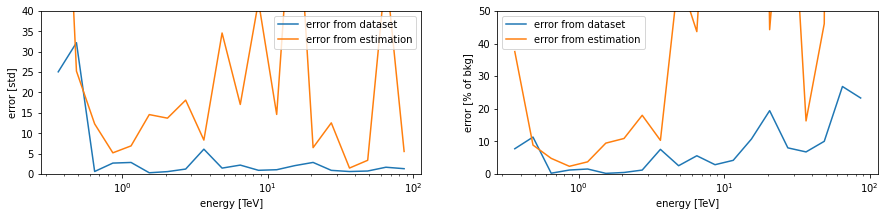

In [23]:
c = np.sum((stacked.counts*stacked.mask_safe).data, axis=(1,2))
b = np.sum((stacked.background*stacked.mask_safe).data, axis=(1,2))
error_std= abs(c-b)/np.sqrt(b)
error_percentage= 100*abs(c-b)/b

fig, ax = plt.subplots(1,2, figsize=(15, 3))

m = ~np.isnan(error_std)
ax[0].plot(x_axis, error_std, label='error from dataset')
ax[0].plot(x_axis[m], sys_er[m], label='error from estimation')
ax[0].set_xscale('log')
ax[0].set_ylabel(f'error [std]')
ax[0].legend()
ax[0].set_xlabel('energy [TeV]')
ax[0].set_ylim(0,40)

ax[1].plot(x_axis, error_percentage, label='error from dataset')
ax[1].plot(x_axis, 100*sys_er/np.sqrt(b), label='error from estimation')
ax[1].set_xscale('log')
ax[1].set_ylabel(f'error [% of bkg]')
ax[1].legend()
ax[1].set_ylim(0,50)
ax[1].set_xlabel('energy [TeV]')